# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import glob

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import scipy.misc

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
#   raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

C:\tensorflow\models\research\object_detection\utils\visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# # What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [5]:
# What model to download.
MODEL_NAME = 'inference_graph'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'label_map.pbtxt')

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

NUM_CLASSES = 1

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [18]:
def load_image_into_numpy_array(image):
  print(image.size)
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'images\test'
# TEST_IMAGE_PATHS = glob.glob(r'C:\Users\20175863\Documents\Ocean Cleanup\project\final_dataset\all_images\*.jpg')
TEST_IMAGE_PATHS = glob.glob(r'C:\Users\20175863\Documents\Ocean Cleanup\project\drones\flight_3\*.jpg')
# TEST_IMAGE_PATHS = glob.glob(r'C:\tensorflow\models\research\object_detection\images\masking_tutorial_bridge footage_vector analysis\*.png')
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 20) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
def parse_title(path):
    path_split = path.split('\\')
    title = path_split[-1]

#     #remove .jpg extension
#     title_split = title.split('.')
#     title = title_split[0]
    return title

In [11]:
parse_title(TEST_IMAGE_PATHS[1])

IndexError: list index out of range

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

(1920, 1080)


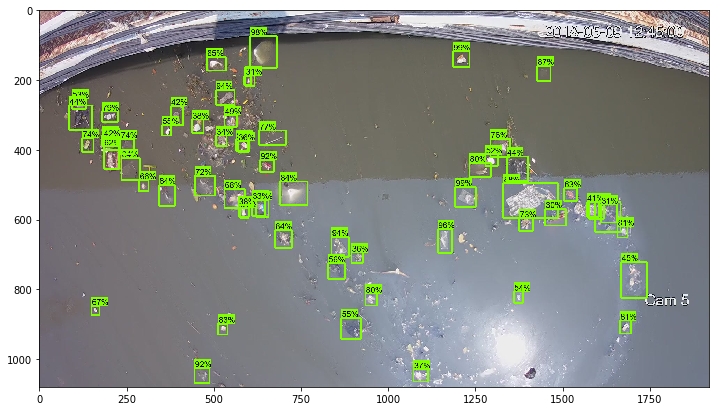

In [19]:
# test_im = 'shanghai_test.jpg'
test_im = r'C:\Users\20175863\Documents\Ocean Cleanup\thesis\project\final_dataset\images\Kaliadem_Location_5_2018-05-09_12-45-00-05_cam5.jpg'
# test_im = r'C:\Users\20175863\Documents\Ocean Cleanup\project\final_dataset\images\Grogol_Location_2_2018-05-02 12-15-00-05_cam7.jpg'
# test_im = TEST_IMAGE_PATHS[7]
image = Image.open(test_im)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    max_boxes_to_draw = 100,
    min_score_thresh=.3,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=5,
#     skip_scores = True,
    skip_labels = True
)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

# scipy.misc.toimage(image_np, cmin=0.0, cmax=...).save(r"C:\Users\20175863\Documents\Ocean Cleanup\project\tensorflow_api\Kaliadem_Location_5_2018-05-09_12-45-00-05_cam5.jpg")

In [17]:
output_dict['detection_boxes']

array([[0.10979168, 0.6178803 , 0.1501942 , 0.642337  ],
       [0.46859896, 0.62098294, 0.5224628 , 0.65179735],
       [0.06933796, 0.31516325, 0.1540265 , 0.35572326],
       ...,
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [13]:
col_names = ['filename', 'width', 'height', 'class', 'xmin', 'xmax', 'ymin', 'ymax', 'score']

# output_dict

def image_result_to_df():
    boxes_df = pd.DataFrame(output_dict['detection_boxes'], columns = ['xmax', 'xmin', 'ymax', 'ymin'])
    classes_df = pd.DataFrame(output_dict['detection_classes'], columns = ['class'])
    scores_df = pd.DataFrame(output_dict['detection_scores'], columns = ['score'])

    output_df = pd.concat([boxes_df, classes_df, scores_df], axis=1)
    output_df['filename'] = parse_title(image_path)
    output_df['width'] = image_np.shape[1]
    output_df['height'] = image_np.shape[0]
    output_df = output_df[col_names]
    output_df = output_df[output_df['score'] >= 0.01]
    return output_df

comb_df = pd.DataFrame(columns = col_names)

In [18]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        min_score_thresh=.3,
        max_boxes_to_draw = 100,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=3,
#         skip_scores=True,
        skip_labels=True)
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(image_np)
    
#     #store image

    scipy.misc.toimage(image_np, cmin=0.0, cmax=...).save(os.path.join(r"C:\Users\20175863\Documents\Ocean Cleanup\project\drones\flight_3_output", parse_title(image_path)))
    
    #convert to dataframe
    temp_df = image_result_to_df()
    comb_df = pd.concat([comb_df, temp_df])

C:\Users\20175863\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


In [19]:
# # TODO make this a map dict
# for i in range(len(comb_df)):
#     if comb_df.iloc[i, 3] == 1:
#         comb_df.iloc[i, 3] = 'plastic'
#     else:
#         comb_df.iloc[i, 3] = 'organic'

In [20]:
len(comb_df)

2312

In [21]:
sum(comb_df['score'])

462.82139272242785

In [29]:
agg_df = comb_df[['filename', 'score']]
agg_df = agg_df.groupby('filename').sum().reset_index()
agg_df['score'] = round(agg_df['score'])

In [30]:
agg_df.head()

,filename,score
0,DJI_0445.JPG,12.0
1,DJI_0446.JPG,12.0
2,DJI_0447.JPG,11.0
3,DJI_0448.JPG,11.0
4,DJI_0449.JPG,12.0


In [31]:
agg_df.to_csv(r"C:\Users\20175863\Documents\Ocean Cleanup\project\drones\drones_output.csv", index = None)

In [ ]:
def draw_bboxes(image, boxes, labels, show_labels, thickness=1):
    """
    Draw bounding boxes on top of an image
    Args:
        image : PIL image to be modified
        boxes: An (N, 4) array of boxes to draw, where N is the number of boxes.
        classes: An (N, 1) array of labels corresponding to each bounding box.
    Returns:
        An array of the same shape as 'image' with bounding boxes and classes drawn
    """
    draw = ImageDraw.Draw(image)

    for i in range(len(boxes)):
        xmin, ymin, xmax, ymax = boxes[i]
        c = labels[i]

        if show_labels:
            draw.text((xmin + 15, ymin + 15), str(c))

        color = 'blue' if c == 'organic' else 'green'

        for j in range(thickness):
            draw.rectangle(((xmin + j, ymin + j), (xmax + j, ymax + j)), outline=color)
    return image